In [21]:
# TODO: replace df with dataframe
# TODO: investigate presence of multiple 'Plate ID' columns in condition_summary
# TODO: add dataset selector (or make new notebooks for analyzing different datasets - this might be better, think about it.)

In [22]:
execfile('./src/display_utils.py')
execfile('./src/moldev_utils.py')
%matplotlib inline
from scipy.stats.kde import gaussian_kde
import scipy.signal as signal
from toolz import thread_last
from scipy.stats import ks_2samp

In [23]:
cell_path = '../moldev-data/analyzed/07-15-2015/ssC PNA.csv'
well_path = '../moldev-data/analyzed/07-15-2015/ssC PNA-wells.csv'
condition_path = '../moldev-data/analyzed/07-15-2015/ssC PNA-conditions.csv'

# cell_path = '../moldev-data/analyzed/07-15-2015/APB PNA.csv'
# well_path = '../moldev-data/analyzed/07-15-2015/APB PNA-wells.csv'
# condition_path = '../moldev-data/analyzed/07-15-2015/APB PNA-conditions.csv'

colors = {'Blue & Red':'bwr','Blue':'Blues'}

In [24]:
well_data = pd.read_csv(well_path)

condition_data = pd.read_csv(condition_path)

raw_cell_data = pd.read_csv(cell_path)
# cell_data = add_condition_cols(raw_cell_data)

# Add cell phase information

In [25]:
# DataFrame -> String -> (a | [a] | Series[a]) -> DataFrame
def add_col(dataframe,colname,values):
    "Add column to dataframe with given values."
    dataframe[colname] = values
    return dataframe

In [26]:
# [Float] -> Float
def get_threshold(intensity,bw = 0.35):
    """ Given an array of intensities, find the intensity 
        threshold separating the G1 peak from the S/G2 peak. """
    kde_fit = gaussian_kde(intensity,bw)
    x = np.linspace(min(intensity),
                    max(intensity),
                    1000)
    y = kde_fit(x)
    ddx = np.diff(np.diff(y)) # second derivative of fit
    peak = np.argmin(ddx) # most frequent intensity 
    index = min([yi for yi in signal.argrelmax(ddx)[0] if yi > peak])
    threshold = x[index]
    return threshold

In [27]:
def label_cell_phase(dataframe):
    col = 'NucIntegrated Intensity_Avg'
    threshold = get_threshold(dataframe[col])
    dataframe['Cell Phase'] = dataframe[col].map(
        lambda intensity: 'G1' if intensity < threshold else 'S/G2')
    dataframe['Cell Phase Threshold'] = threshold
    dataframe['Condition'] = dataframe['Condition'] + ' ' + dataframe['Cell Phase']
    return dataframe

In [28]:
def label_cell_phase_2(dataframe_orig):
    dataframe = dataframe_orig.copy()
    col = 'NucIntegrated Intensity_Avg'
    threshold = get_threshold(dataframe[col])
    dataframe['Cell Phase'] = dataframe[col].map(
        lambda intensity: 'G1' if intensity < threshold else 'S/G2')
    dataframe['Cell Phase Threshold'] = threshold
    dataframe['Condition'] = dataframe['Cell Type'] + ' ' + dataframe['Cell Phase']
    return dataframe

In [29]:
phased_conditions = thread_first(
    raw_cell_data,
    lambda x: x.groupby('Condition'),
    lambda xs: map(snd,xs),
    lambda conditions: map(label_cell_phase,conditions))

In [30]:
phased_conditions_by_cell_type = thread_first(
    raw_cell_data,
    lambda x: x.groupby('Cell Type'),
    lambda xs: map(snd,xs),
    lambda conditions: map(label_cell_phase_2,conditions))

In [31]:
by_cell_type = thread_last(
    raw_cell_data,
    lambda x: x.groupby('Cell Type'),
    lambda x: map(snd,x),
    (map,lambda x: add_col(x,'Condition',x['Cell Type'])))

In [32]:
# mydf = pd.DataFrame({'a':[1,2,3],'b':[10,20,30],'c':[100,200,300]})

# def f(x):
#     print x
#     return x['a'] * 2
# mygroups = mydf.groupby(f,axis=0)

In [33]:
phased_conditions_by_cell_type = thread_first(
    raw_cell_data,
    lambda x: x.groupby('Cell Type'),
    lambda xs: map(snd,xs),
    lambda conditions: map(label_cell_phase_2,conditions))

In [34]:
phased_conditions[0].head()[['Condition','Cell Phase','Cell Phase Threshold']]

,Condition,Cell Phase,Cell Phase Threshold
897,ssC PNA ssC 12.5 nM 143B G1,G1,14065835.792793
898,ssC PNA ssC 12.5 nM 143B G1,G1,14065835.792793
899,ssC PNA ssC 12.5 nM 143B S/G2,S/G2,14065835.792793
900,ssC PNA ssC 12.5 nM 143B S/G2,S/G2,14065835.792793
901,ssC PNA ssC 12.5 nM 143B G1,G1,14065835.792793


In [35]:
thresholded_data = pd.concat(phased_conditions)
thresholded_data_by_cell_type = pd.concat(phased_conditions_by_cell_type)
all_by_cell_type = pd.concat(by_cell_type)

In [36]:
raw_cell_data = pd.concat([all_by_cell_type,thresholded_data_by_cell_type,raw_cell_data, thresholded_data])

---
# Well Plate Results

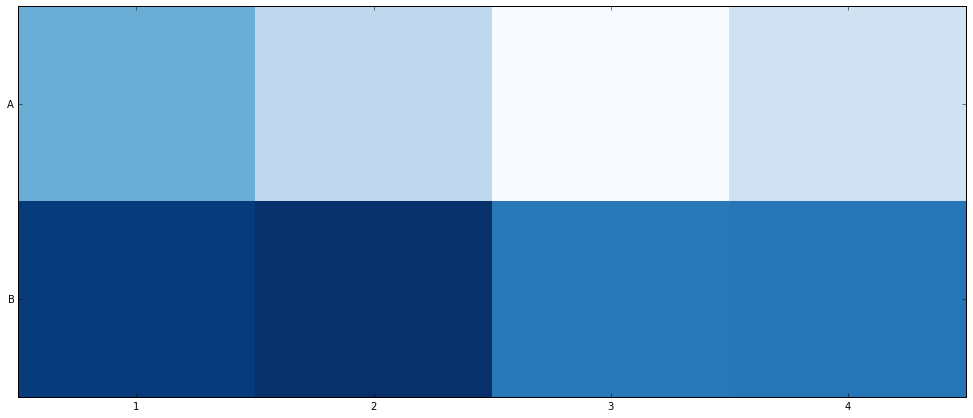

In [37]:
interact(plot_plates, 
         dataframe = fixed(well_data),
         parameter = widgets.Select(value = 'Cell Count',
                                    options= get_params(well_data),
                                    height=250),
         function = well_data['Function'].unique().tolist(),
         color = colors,
         show = widgets.ToggleButtons(options=['None','Values','Conditions']));

---
# How do conditions cluster together?

In [38]:
data = pipe(condition_data,
            get_means,
            lambda x: x.set_index('Condition'),
            lambda x: pd.DataFrame.drop(x,['Cell Type','Concentration'],axis=1),
            normalize_columns(fillna=True))
data_without_empty_params = data.dropna(axis=1,how='all')

In [39]:
params_without_data = sorted(set(data.columns).difference(data_without_empty_params.columns))

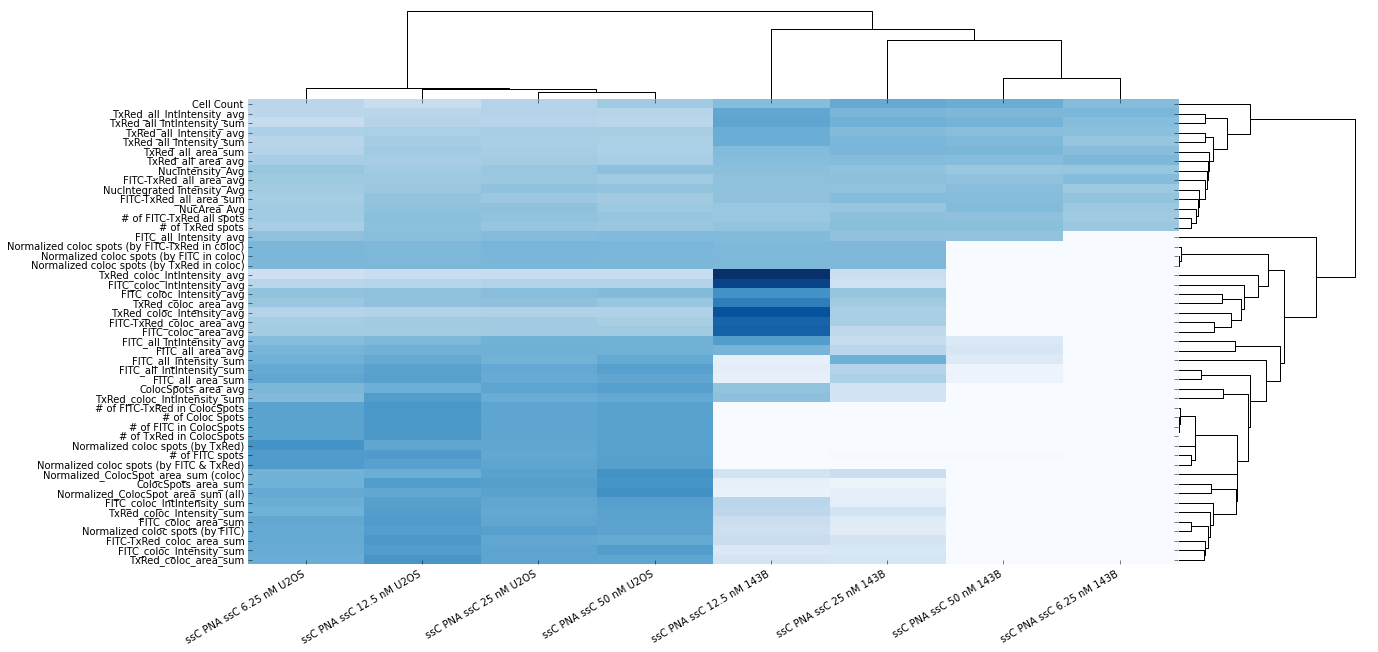

In [40]:
interact(matrix_tree, data = fixed(data_without_empty_params), color = colors);

---
# Heatmap subsets
The last selection box allows you to show parameters that are missing data. They shouldn't really affect clustering.

In [41]:
def wrapper(conditions,features,color):
    df = data.loc[list(conditions)][list(features)]
    try: 
        matrix_tree(df,color)
    except:
        print "\n".join(["-"*50, "Please select multiple features and conditions.","-"*50])

subset = interactive(wrapper,
                     conditions = widgets.SelectMultiple(options = data_without_empty_params.index.values.tolist(), height = 300),
                     features = widgets.SelectMultiple(options = data_without_empty_params.columns.values.tolist(), height = 300),
                     color = colors)
subset

--------------------------------------------------
Please select multiple features and conditions.
--------------------------------------------------


---
# How do parameters vary with drug dose?

In [42]:
# dose_data = thread_first(condition_data,
#                         lambda df: df[df['Function'] == 'avg'],
#                         add_condition_cols)

# dose_error = thread_first(condition_data,
#                         lambda df: df[df['Function'] == 'sem'],
#                         add_condition_cols)

In [43]:
# interact(dose_plot,
#          scale = widgets.ToggleButtons(options=['linear','log']), 
#          df = fixed(dose_data),
#          err = fixed(dose_error),
#          cols = widgets.SelectMultiple(value = ['Cell Count'],
#                               options= [col for col in dose_data.columns.values.tolist() if col not in ['Condition','Function','Base','Dose','Unit','Drug']],
#                               height=250));

---
#How are different parameters related?

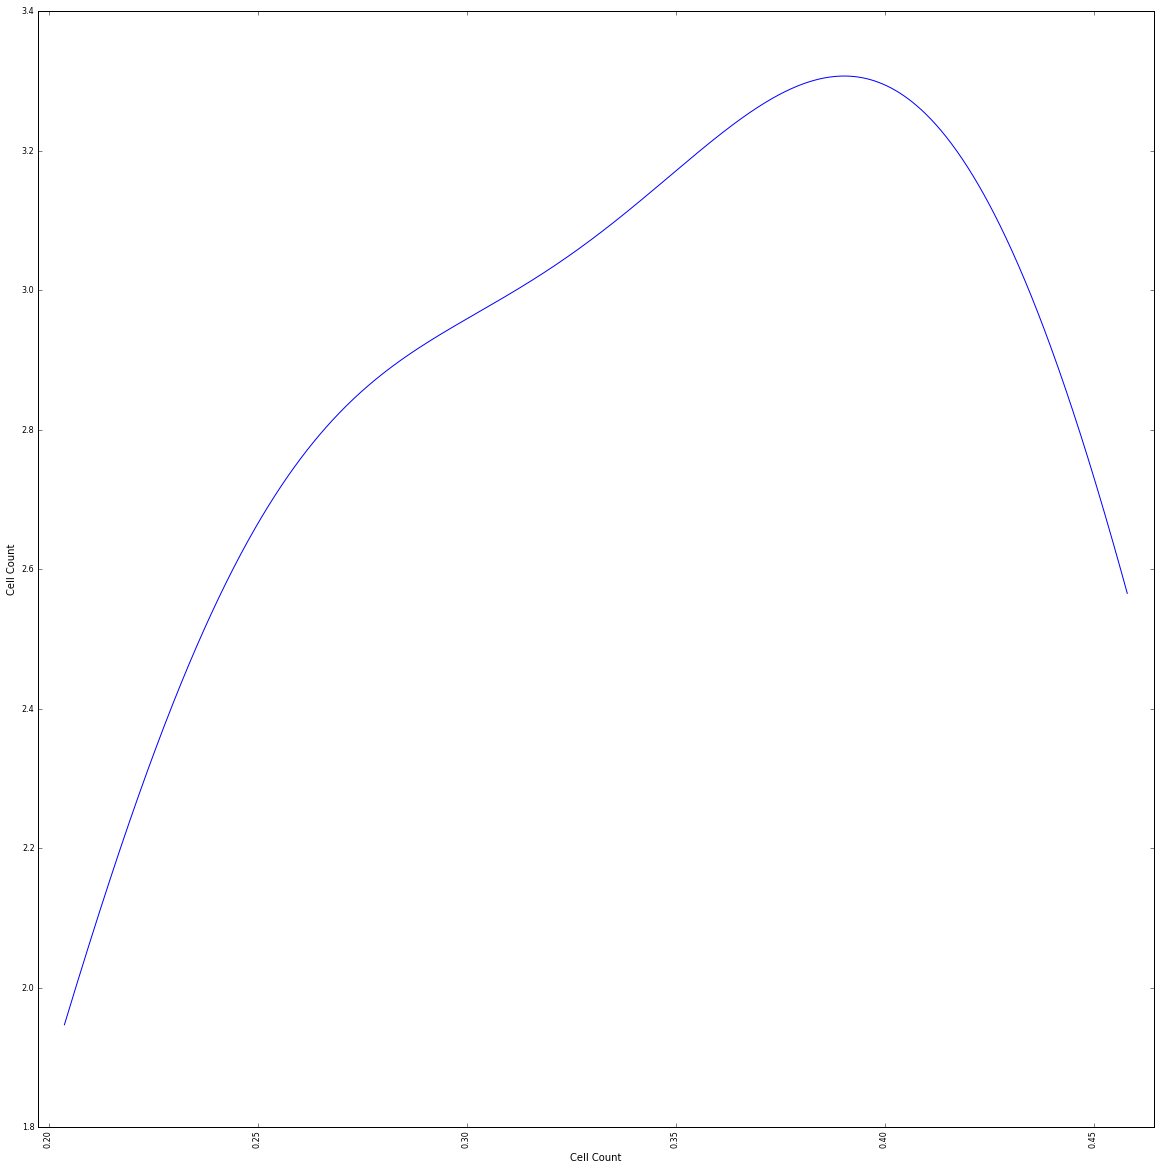

In [44]:
from pandas.tools.plotting import scatter_matrix

def scatter(df,cols):
    scatter_matrix(data[list(cols)], alpha=1, figsize=(20, 20), diagonal='kde');
    
interact(scatter, 
         df = fixed(data),
         cols = widgets.SelectMultiple(value = ['Cell Count'],
                              options= get_params(data),
                              height=250));

---
# Parameter vs. Conditions

In [45]:
def plot_dist(data,parameters):        
    fig = plt.figure(num=None, figsize=(15, 7), dpi=100, facecolor='w', edgecolor='k')
    
    reshaped_data = pd.concat([add_col(data[['Condition',parameter]].rename(columns={parameter: 'Value'}),'Parameter',parameter) for parameter in parameters])
    
    sns.boxplot(x = 'Condition',
                y = 'Value',
                hue = 'Parameter',
                data = reshaped_data,
                order = sorted(data.Condition.unique()))    
    
#     plt.ylabel(parameter,fontsize=20)
    plt.xlabel('Condition',fontsize=20)
    plt.title('Distribution: ' + parameter,fontsize=20)
    plt.tick_params(labelsize=10)
    plt.xticks(rotation=30,ha='right')
    mean = data[parameter].mean()
    plt.gca().set_ylim(bottom=data[parameter].mean() * -0.5)

In [46]:
def dist_wrapper(parameters,conditions):
    conditions = list(conditions)
    if list(parameters) == ['Cell Count']:
        dataframe = thread_first(well_data,
                                 (filter_rows,'Function','avg'),
                                 (filter_rows,'Condition',conditions))
        plot_dist(dataframe,parameters)
    else: 
        if 'Cell Count' in parameters:
            print "Ignoring cell count. Select it by itself if you want to see it."
        dataframe = filter_rows(raw_cell_data,'Condition',conditions)
        plot_dist(dataframe,filter(lambda x: x != 'Cell Count',parameters))

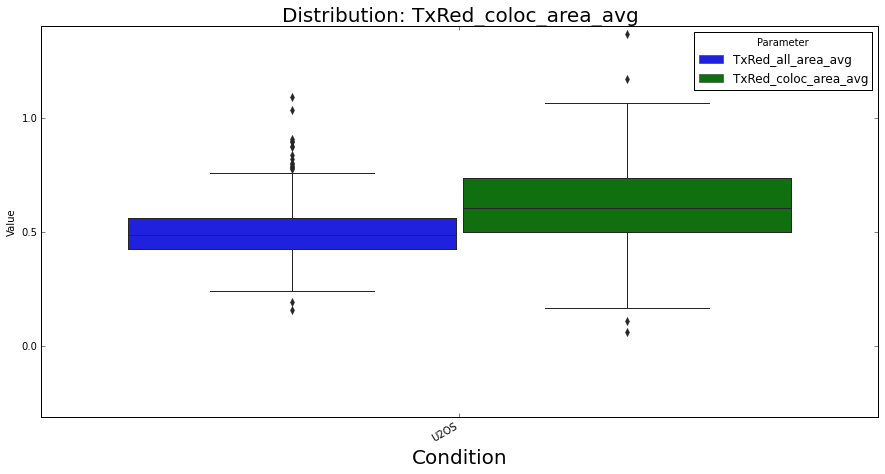

In [47]:
interactive(dist_wrapper,
            parameters = widgets.SelectMultiple(options = get_params(raw_cell_data) + ['Cell Count'],height = 300),
            conditions = widgets.SelectMultiple(options = sorted(raw_cell_data.Condition.unique().tolist(),key = lambda x: x.split(' ')[-1]),height = 300))

---
# Compare conditions

In [48]:
raw_cell_data['Cell Phase Threshold'].unique()


array([               nan,  15518881.56556557,  11655100.84384384,
        14065835.79279279,  11668791.44844845,  15571072.43243243,
        12526201.85285285,  16817878.08208209,  11418294.15815816,
        12357265.94194194,  10091842.55255255])

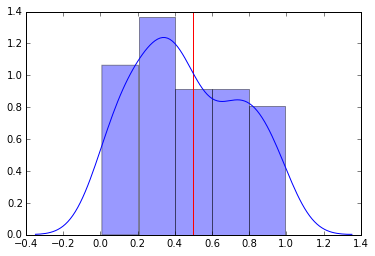

In [49]:
sns.distplot(np.random.random(100))
# plt.plot([0.5,0.5],[0,1])
plt.vlines(0.5,0,plt.gca().get_xlim()[1],color='r')

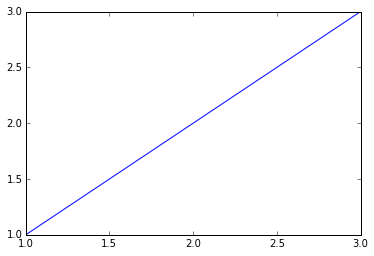

In [50]:
plt.plot([1,2,3],[1,2,3])
# plt.vlines(threshold,0,plt.gca().get_xlim()[1],color='r')


In [51]:
def compare_condition_dists(df, conditions, parameters, bandwidth=0.1, shaded = True, clip_ends = False, scale='linear'):
    n_rows = int(np.ceil(len(parameters)/3.0))
    plt.figure(figsize=(20,4 * n_rows))
    subs = gridspec.GridSpec(n_rows, 3) 
    plt.subplots_adjust(hspace=0.54,wspace=0.27)

    for parameter,sub in zip(parameters,subs):
        plt.subplot(sub)
        param_bandwidth = bandwidth * df[df.Condition == conditions[0]][parameter].mean()
        for condition in conditions:
            data = df[df.Condition == condition][parameter]
            kws = {"shade": shaded, "bw": param_bandwidth}
            if clip_ends: 
                kws = assoc(kws,"cut",0)
            sns.distplot(data, hist=False, kde_kws=kws,label=condition)
            plt.legend(loc = 0,fontsize=8)
            if parameter == 'NucIntegrated Intensity_Avg':
                thresholds = df[df.Condition == condition]['Cell Phase Threshold'].unique().tolist()
                print thresholds
                for threshold in thresholds:
                    plt.plot([threshold,threshold],plt.gca().get_ylim(),color='r')
                
        if scale == 'linear':
            plt.xlim(left=0)
        else:
            plt.xscale('log')
        plt.ylabel('Frequency')

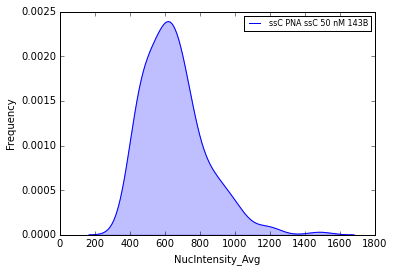

In [52]:
try:    
    interact(compare_condition_dists,
             df = fixed(raw_cell_data),
             conditions = widgets.SelectMultiple(options = raw_cell_data.Condition.unique().tolist(),height = 300),
             parameters = widgets.SelectMultiple(options = get_params(raw_cell_data),height = 300),
             bandwidth = (0,0.2,0.01),
             scale = widgets.ToggleButtons(options=['linear','log']));
except ValueError: 
    raise Exception("Hmm. That didn't work. Maybe one of the conditions or parameters you selected doesn't have any data.")

---
# Compare parameters

In [53]:
def compare_parameter_dists(df, conditions, parameters, bandwidth=0.1, shaded = True, clip_ends = False, scale='linear'):
    n_rows = int(np.ceil(len(conditions)/3.0))
    plt.figure(figsize=(20,4 * n_rows))
    subs = gridspec.GridSpec(n_rows, 3) 
    plt.subplots_adjust(hspace=0.54,wspace=0.27)

    for condition,sub in zip(conditions,subs):
        plt.subplot(sub)
        condition_bandwidth = bandwidth * df[df.Condition == condition][parameters[0]].mean()
        for parameter in parameters:
            data = df[df.Condition == condition][parameter]
            kws = {"shade": shaded, "bw": condition_bandwidth}
            if clip_ends: 
                kws = assoc(kws,"cut",0)
            sns.distplot(data, hist=False, kde_kws=kws,label=parameter)
            plt.legend(loc = 0,fontsize=8)
        if scale == 'linear':
            plt.xlim(left=0)
        else:
            plt.xscale('log')
        plt.ylabel('Frequency')
        plt.xlabel(condition)

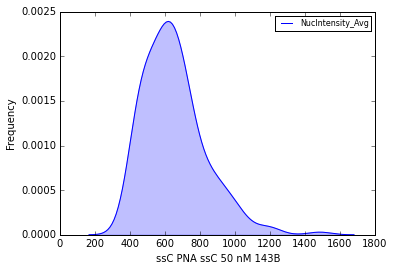

In [54]:
interact(compare_parameter_dists,
         df = fixed(raw_cell_data),
         conditions = widgets.SelectMultiple(options = raw_cell_data.Condition.unique().tolist(),height = 300),
         parameters = widgets.SelectMultiple(options = get_params(raw_cell_data),height = 300),
         bandwidth = (0,0.2,0.01),
         scale = widgets.ToggleButtons(options=['linear','log']));

In [55]:
def check_significance(data,control,comparisons,parameter):
    conditions = thread_last(
        data[['Condition',parameter]].groupby('Condition'),
        (map,lambda group: (group[0],group[1][parameter].values)),
        dict)
    control_data = conditions[control]
    results = [{'Condition':comparison,
                'KS-value':ks_2samp(control_data,conditions[comparison])[0],
                'P-value': ks_2samp(control_data,conditions[comparison])[1]} for comparison in comparisons]
    df = pd.DataFrame(results)
    print "Control: {}".format(control)
    display(df)
    df.set_index('Condition').plot(kind = 'bar')
    plt.title("Parameter: {}".format(parameter))

Control: 143B


,Condition,KS-value,P-value
0,ssC PNA ssC 50 nM 143B,0.005215,1


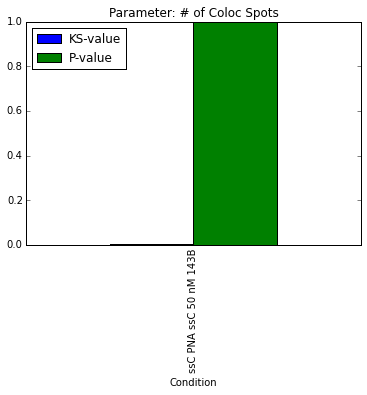

In [56]:
interact(
    check_significance,
    data = fixed(raw_cell_data),
    control = widgets.Select(options = raw_cell_data.Condition.unique().tolist(),height = 300),
    comparisons = widgets.SelectMultiple(options = raw_cell_data.Condition.unique().tolist(),height = 300),
    parameter = widgets.Select(options = get_params(raw_cell_data),height = 300));